## Introdução

O objetivo deste trabalho é explorar representações de baixa dimensão de imagens do conjunto de dados MNIST e sua posterior reconstrução usando três arquiteturas diferentes de autoencoders: feedforward, convolucional e variacional. Para atingir esse objetivo, os modelos foram treinados de maneiras distintas, utilizando perdas apenas para reconstrução, perdas de classificação auxiliar e diferentes tamanhos de espaço latente.

### Arquiteturas Utilizadas

#### Autoencoder Feedforward

Os autoencoders feedforward são redes neurais totalmente conectadas que comprimem a entrada em uma representação de menor dimensão e, em seguida, tentam reconstruir a entrada original a partir dessa representação comprimida. Eles são compostos por um encoder, que mapeia a entrada para o espaço latente, e um decoder, que reconstrói a entrada a partir do espaço latente.

#### Autoencoder Convolucional

Já os autoencoders convolucionais utilizam camadas convolucionais em suas camadas de encoder e decoder. Em particular, o decoder é composto por convoluções tranpostas que conseguem restaurar o tamanho original da imagem após a redução aplicada pelo encoder. 

#### Autoencoder Variacional (VAE)

Os autoencoders variacionais são uma classe especial de autoencoders que geram uma distribuição probabilística sobre o espaço latente. Em vez de aprender uma única representação latente para cada entrada, o VAE aprende parâmetros de uma distribuição (tipicamente gaussiana) a partir da qual as representações latentes são amostradas.



In [1]:
%run "main.py"

AutoEncoder(
  (encoder): Sequential(
    (linear_784_128): Linear(in_features=784, out_features=128, bias=True)
    (act_128): ReLU()
    (linear_128_64): Linear(in_features=128, out_features=64, bias=True)
    (act_64): ReLU()
    (linear_64_32): Linear(in_features=64, out_features=32, bias=True)
    (act_32): ReLU()
    (linear_latente): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (linear_2_32): Linear(in_features=2, out_features=32, bias=True)
    (act_32): ReLU()
    (linear_32_64): Linear(in_features=32, out_features=64, bias=True)
    (act_64): ReLU()
    (linear_64_128): Linear(in_features=64, out_features=128, bias=True)
    (act_128): ReLU()
    (latente_linear): Linear(in_features=128, out_features=784, bias=True)
  )
)
Epoch: 1/5, Loss: 0.0510
Epoch: 2/5, Loss: 0.0437
Epoch: 3/5, Loss: 0.0415
Epoch: 4/5, Loss: 0.0401
Epoch: 5/5, Loss: 0.0393
AutoEncoder(
  (encoder): Sequential(
    (conv_1_16): Conv2d(1, 16, kernel_size=(3, 3), stride

Os exemplos a seguir possuem um espaço latente de dimensão 2. Tanto a rede convolucional quanto a feedforward usam a perda quadrática entre a imagem reconstruída e a imagem original durante o treinamento. A perda total do autoencoder variacional é composta por duas outras perdas: a perda de reconstrução e a perda da Kullback-Leibler (KL). A divergência de Kullback-Leibler mede a dissimilaridade entre a distribuição latente aprendida pelo modelo e uma distribuição gaussiana padrão (normal), $ \mathcal{N}(0, I) $. Dessa maneira, a distribuição latente é forçada a ser próxima de uma gaussiana normal, promovendo uma estrutura organizada e contínua.
   - A fórmula para a perda KL é: 
     $$
     \mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum_{i=1}^N \left(1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2\right)
     $$
     onde $ \mu_i $ e $ \sigma_i $ são os parâmetros da distribuição latente para a $ i $-ésima dimensão.


Nota-se que o encoder não é capaz de separar muito bem os diversos tipos de imagens, com exceção do dígito 1 na rede feedforward e dos dígitos 0 e 1 na rede convolucional, que aparentam estar dentro de um cluster bem definido. Além disso, as reconstruções parecem ter sido afetadas pelo tamanho reduzido da dimensão do espaço latente.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


In [13]:
class MLPAutoEncoder(nn.Module):
    def __init__(self, latente_dim=2, classify=False):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latente_dim)
        )
        if classify:
            self.classifier = nn.Linear(2, 10)
            
        self.decoder = nn.Sequential(
            nn.Linear(latente_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, latente_dim=2, classify=False):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(30976, latente_dim)
        )
        if classify:
            self.classifier = nn.Linear(2, 10)
        self.decoder = nn.Sequential(
            nn.Linear(latente_dim, 30976),
            nn.Unflatten(dim=1, unflattened_size=(64, 22, 22)),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class VAE(nn.Module):
    def __init__(self, latente_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latente_dim),
            nn.Linear(32, latente_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latente_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784)
        )
        
    def sample(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        for module in self.encoder[:-2]:
            x = module(x)

        mu = self.encoder[-1](x)
        logvar = self.encoder[-2](x)
        return mu, logvar

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)

    def forward(
        self, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z)

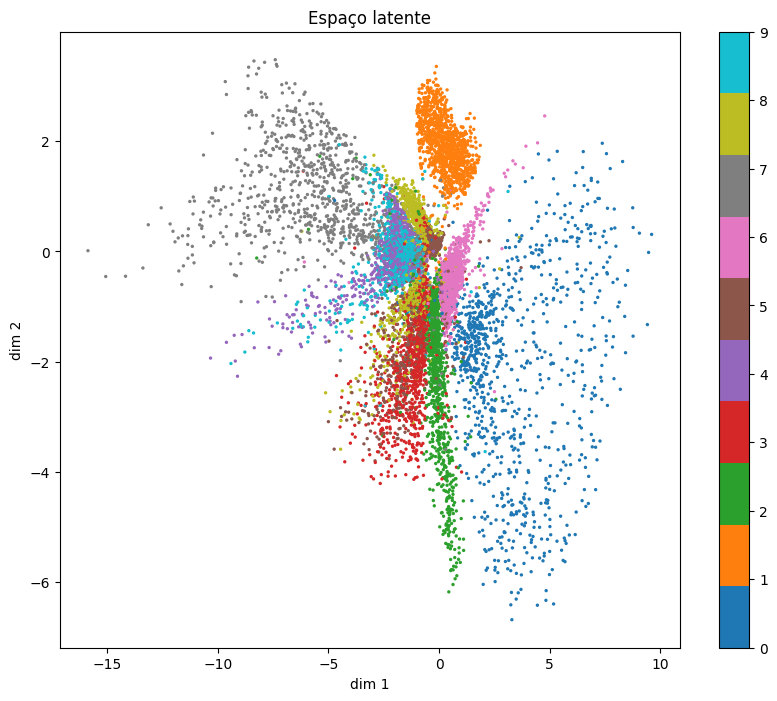

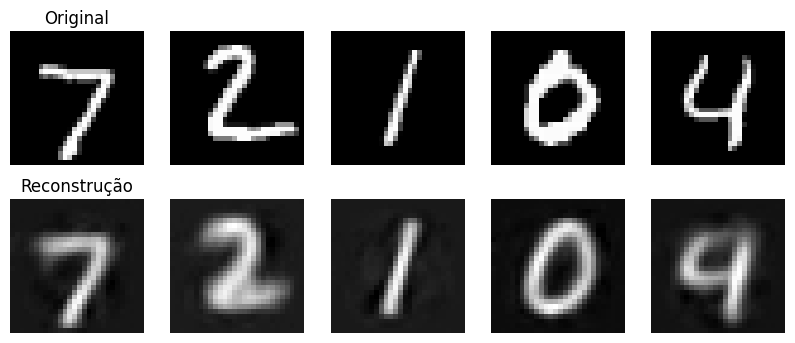

In [4]:
model = MLPAutoEncoder()
state_dict = torch.load('models/model_mlp_2.pth')

state_dict = {
    'encoder.0.weight': state_dict['encoder.linear_784_128.weight'],
    'encoder.0.bias': state_dict['encoder.linear_784_128.bias'],
    'encoder.2.weight': state_dict['encoder.linear_128_64.weight'],
    'encoder.2.bias': state_dict['encoder.linear_128_64.bias'],
    'encoder.4.weight': state_dict['encoder.linear_64_32.weight'],
    'encoder.4.bias': state_dict['encoder.linear_64_32.bias'],
    'encoder.6.weight': state_dict['encoder.linear_latente.weight'],
    'encoder.6.bias': state_dict['encoder.linear_latente.bias'],
    'decoder.0.weight': state_dict['decoder.linear_2_32.weight'],
    'decoder.0.bias': state_dict['decoder.linear_2_32.bias'],
    'decoder.2.weight': state_dict['decoder.linear_32_64.weight'],
    'decoder.2.bias': state_dict['decoder.linear_32_64.bias'],
    'decoder.4.weight': state_dict['decoder.linear_64_128.weight'],
    'decoder.4.bias': state_dict['decoder.linear_64_128.bias'],
    'decoder.6.weight': state_dict['decoder.latente_linear.weight'],
    'decoder.6.bias': state_dict['decoder.latente_linear.bias']
}
model.load_state_dict(state_dict)
model.eval()
def plot_images(original_images, reconstructed_images, n):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstrução')
    plt.show()
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_images, test_labels = next(iter(test_loader))
test_images = test_images.view(-1, 28*28)
encoded_images = model.encoder(test_images).detach().numpy()
test_labels = test_labels.numpy()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=test_labels, cmap='tab10', s=2)
plt.colorbar(scatter)
plt.title('Espaço latente')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()

reconstructed_images = model.decoder(torch.tensor(encoded_images[:5])).detach().numpy()
plot_images(test_images, reconstructed_images, 5)

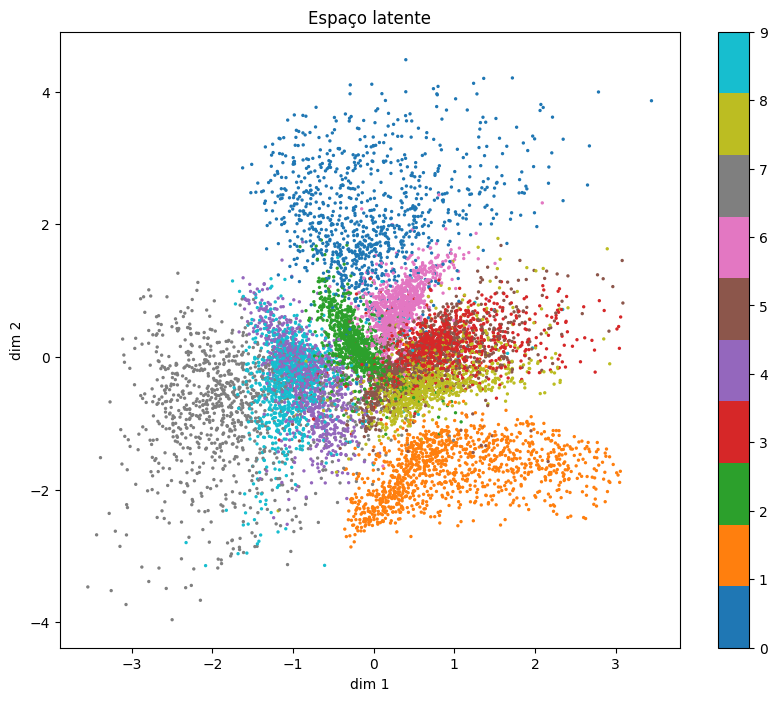

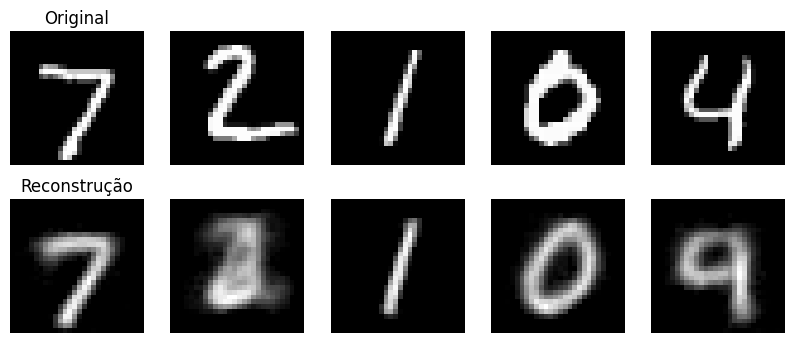

In [5]:
model = ConvolutionalAutoEncoder()
state_dict = torch.load('models/model_conv_2.pth')
state_dict = {
    "encoder.0.weight": state_dict["encoder.conv_1_16.weight"],
    "encoder.0.bias": state_dict["encoder.conv_1_16.bias"],
    "encoder.3.weight": state_dict["encoder.conv_16_32.weight"],
    "encoder.3.bias": state_dict["encoder.conv_16_32.bias"],
    "encoder.6.weight": state_dict["encoder.conv_32_64.weight"],
    "encoder.6.bias": state_dict["encoder.conv_32_64.bias"],
    "encoder.10.weight": state_dict["encoder.linear_latente.weight"],
    "encoder.10.bias": state_dict["encoder.linear_latente.bias"],
    "decoder.0.weight": state_dict["decoder.latente_linear.weight"],
    "decoder.0.bias": state_dict["decoder.latente_linear.bias"],
    "decoder.2.weight": state_dict["decoder.conv_64_64.weight"],
    "decoder.2.bias": state_dict["decoder.conv_64_64.bias"],
    "decoder.4.weight": state_dict["decoder.conv_64_32.weight"],
    "decoder.4.bias": state_dict["decoder.conv_64_32.bias"],
    "decoder.6.weight": state_dict["decoder.conv_32_1.weight"],
    "decoder.6.bias": state_dict["decoder.conv_32_1.bias"]
}
model.load_state_dict(state_dict)
model.eval()
def plot_images(original_images, reconstructed_images, n):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstrução')

    plt.show()
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_images, test_labels = next(iter(test_loader))
encoded_images = model.encoder(test_images).detach().numpy()
test_labels = test_labels.numpy()
test_images = test_images.view(-1, 28*28)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=test_labels, cmap='tab10', s=2)
plt.colorbar(scatter)
plt.title('Espaço latente')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()
reconstructed_images = model.decoder(torch.tensor(encoded_images[:5])).detach().numpy()
plot_images(test_images, reconstructed_images, 5)

/tmp/ipykernel_8688/10778327.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstructed_images = model.forward(torch.tensor(test_images[:5])).detach().numpy()


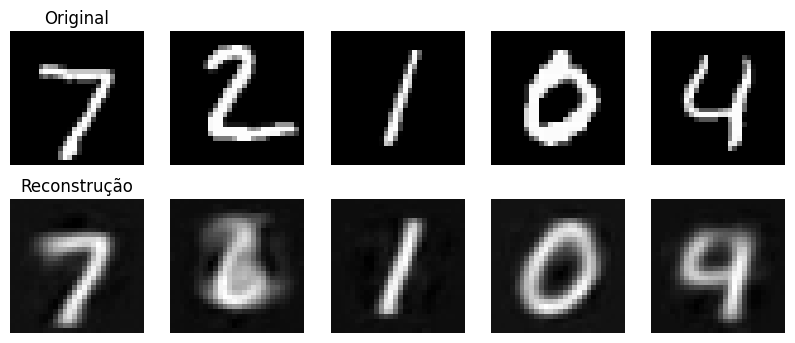

In [15]:
model = VAE()
state_dict = torch.load('models/model_vae_2.pth')
state_dict = {
    "encoder.0.weight": state_dict["encoder.linear_784_128.weight"],
    "encoder.0.bias": state_dict["encoder.linear_784_128.bias"],
    "encoder.2.weight": state_dict["encoder.linear_128_64.weight"],
    "encoder.2.bias": state_dict["encoder.linear_128_64.bias"],
    "encoder.4.weight": state_dict["encoder.linear_64_32.weight"],
    "encoder.4.bias": state_dict["encoder.linear_64_32.bias"],
    "encoder.6.weight": state_dict["encoder.linear_latente1.weight"],
    "encoder.6.bias": state_dict["encoder.linear_latente1.bias"],
    "encoder.7.weight": state_dict["encoder.linear_latente2.weight"],
    "encoder.7.bias": state_dict["encoder.linear_latente2.bias"],
    "decoder.0.weight": state_dict["decoder.linear_2_32.weight"],
    "decoder.0.bias": state_dict["decoder.linear_2_32.bias"],
    "decoder.2.weight": state_dict["decoder.linear_32_64.weight"],
    "decoder.2.bias": state_dict["decoder.linear_32_64.bias"],
    "decoder.4.weight": state_dict["decoder.linear_64_128.weight"],
    "decoder.4.bias": state_dict["decoder.linear_64_128.bias"],
    "decoder.6.weight": state_dict["decoder.latente_linear.weight"],
    "decoder.6.bias": state_dict["decoder.latente_linear.bias"]
}
model.load_state_dict(state_dict)
model.eval()
def plot_images(original_images, reconstructed_images, n):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
        
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstrução')
    plt.show()
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_images, test_labels = next(iter(test_loader))
test_images = test_images.view(-1, 28*28)



reconstructed_images = model.forward(torch.tensor(test_images[:5])).detach().numpy()
plot_images(test_images, reconstructed_images, 5)

Os exemplos gerados a seguir seguem a mesma rotina de treino dos itens anteriores, alterando apenas a dimensão do espaço latente de 2 para 10. Para a visualização em duas dimensões desse novo espaço latente, foi utilizado o método t-SNE.

O t-SNE (t-distributed Stochastic Neighbor Embedding) é uma técnica de redução de dimensionalidade que mapeia dados de alta dimensão em um espaço de menor dimensão enquanto preserva uma certa estrutura local dos dados no caso, os pontos com probabilidade alta de estarem próximos no espaço de alta dimensão tendem a permanecer próximos no espaço de baixa dimensão.

Agora, é possível observar clusters bem definidos para cada um dos diferentes dígitos. Além disso, o novo tamanho do espaço latente parece ter capturado mais informações para a reconstrução realizada pelo decoder, resultando em resultados satisfatórios, especialmente na rede convolucional.


In [1]:
%run "main.py"

AutoEncoder(
  (encoder): Sequential(
    (linear_784_128): Linear(in_features=784, out_features=128, bias=True)
    (act_128): ReLU()
    (linear_128_64): Linear(in_features=128, out_features=64, bias=True)
    (act_64): ReLU()
    (linear_64_32): Linear(in_features=64, out_features=32, bias=True)
    (act_32): ReLU()
    (linear_latente): Linear(in_features=32, out_features=10, bias=True)
  )
  (classifier): Linear(in_features=10, out_features=10, bias=True)
  (decoder): Sequential(
    (linear_10_32): Linear(in_features=10, out_features=32, bias=True)
    (act_32): ReLU()
    (linear_32_64): Linear(in_features=32, out_features=64, bias=True)
    (act_64): ReLU()
    (linear_64_128): Linear(in_features=64, out_features=128, bias=True)
    (act_128): ReLU()
    (latente_linear): Linear(in_features=128, out_features=784, bias=True)
  )
)
Epoch: 1/5, Loss: 0.0416
Epoch: 2/5, Loss: 0.0289
Epoch: 3/5, Loss: 0.0259
Epoch: 4/5, Loss: 0.0240
Epoch: 5/5, Loss: 0.0229
AutoEncoder(
  (encoder):

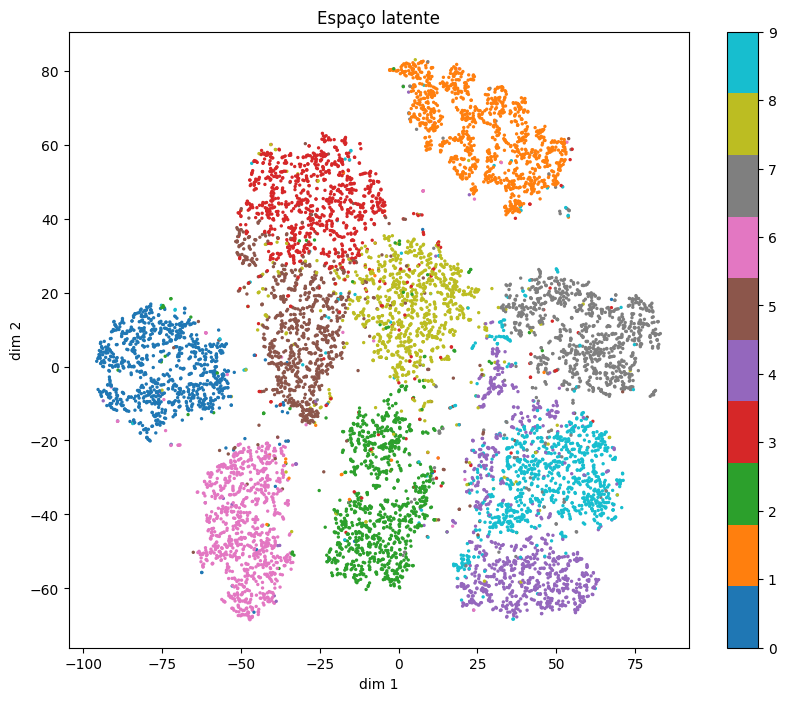

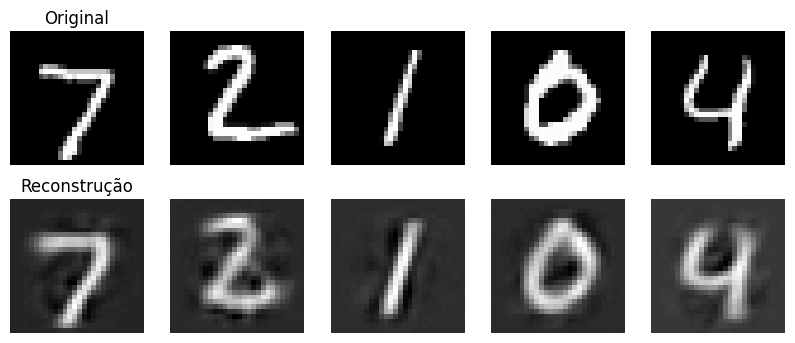

In [20]:
model = MLPAutoEncoder(latente_dim=10)
state_dict = torch.load('models/model_mlp_10.pth')

state_dict = {
    'encoder.0.weight': state_dict['encoder.linear_784_128.weight'],
    'encoder.0.bias': state_dict['encoder.linear_784_128.bias'],
    'encoder.2.weight': state_dict['encoder.linear_128_64.weight'],
    'encoder.2.bias': state_dict['encoder.linear_128_64.bias'],
    'encoder.4.weight': state_dict['encoder.linear_64_32.weight'],
    'encoder.4.bias': state_dict['encoder.linear_64_32.bias'],
    'encoder.6.weight': state_dict['encoder.linear_latente.weight'],
    'encoder.6.bias': state_dict['encoder.linear_latente.bias'],
    'decoder.0.weight': state_dict['decoder.linear_10_32.weight'],
    'decoder.0.bias': state_dict['decoder.linear_10_32.bias'],
    'decoder.2.weight': state_dict['decoder.linear_32_64.weight'],
    'decoder.2.bias': state_dict['decoder.linear_32_64.bias'],
    'decoder.4.weight': state_dict['decoder.linear_64_128.weight'],
    'decoder.4.bias': state_dict['decoder.linear_64_128.bias'],
    'decoder.6.weight': state_dict['decoder.latente_linear.weight'],
    'decoder.6.bias': state_dict['decoder.latente_linear.bias']
}
model.load_state_dict(state_dict)
model.eval()
def plot_images(original_images, reconstructed_images, n):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstrução')
    plt.show()
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_images, test_labels = next(iter(test_loader))
test_images = test_images.view(-1, 28*28)
encoded_images = model.encoder(test_images).detach().numpy()
test_labels = test_labels.numpy()
tsne = TSNE(n_components=2, random_state=42)
encoded_images_2d = tsne.fit_transform(encoded_images)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(encoded_images_2d[:, 0], encoded_images_2d[:, 1], c=test_labels, cmap='tab10', s=2)
plt.colorbar(scatter)
plt.title('Espaço latente')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()

reconstructed_images = model.decoder(torch.tensor(encoded_images[:5])).detach().numpy()
plot_images(test_images, reconstructed_images, 5)

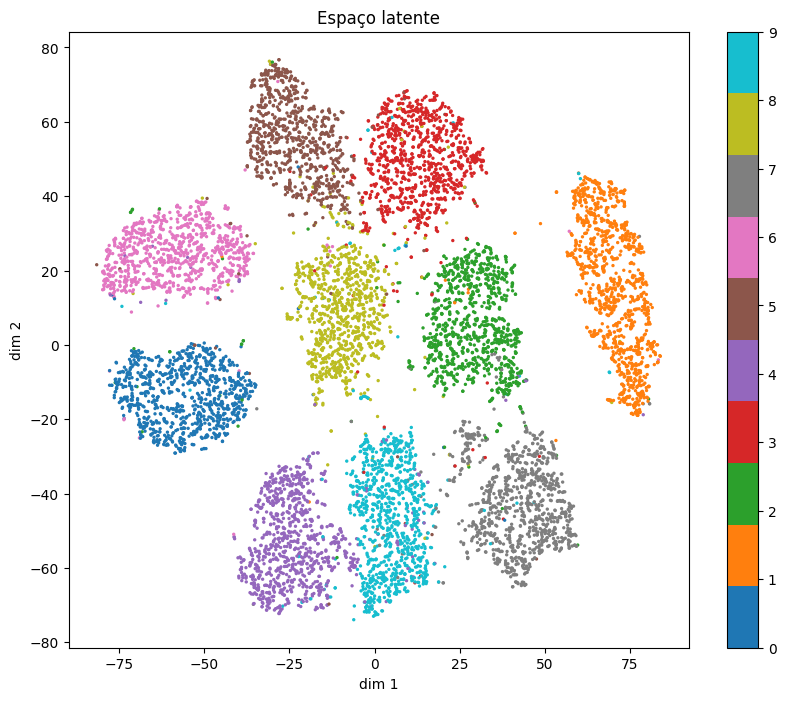

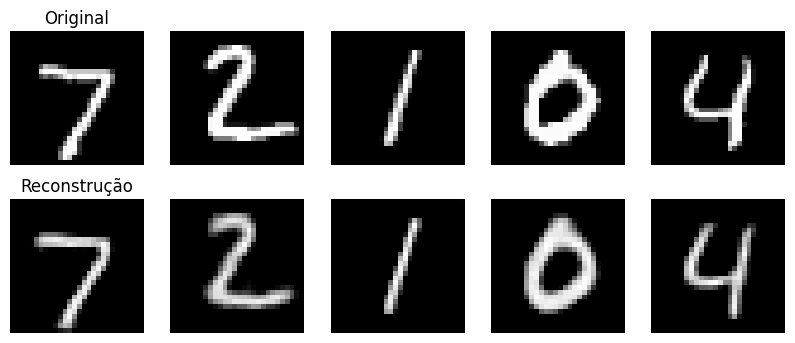

In [22]:
model = ConvolutionalAutoEncoder(latente_dim=10)
state_dict = torch.load('models/model_conv_10.pth')
state_dict = {
    "encoder.0.weight": state_dict["encoder.conv_1_16.weight"],
    "encoder.0.bias": state_dict["encoder.conv_1_16.bias"],
    "encoder.3.weight": state_dict["encoder.conv_16_32.weight"],
    "encoder.3.bias": state_dict["encoder.conv_16_32.bias"],
    "encoder.6.weight": state_dict["encoder.conv_32_64.weight"],
    "encoder.6.bias": state_dict["encoder.conv_32_64.bias"],
    "encoder.10.weight": state_dict["encoder.linear_latente.weight"],
    "encoder.10.bias": state_dict["encoder.linear_latente.bias"],
    "decoder.0.weight": state_dict["decoder.latente_linear.weight"],
    "decoder.0.bias": state_dict["decoder.latente_linear.bias"],
    "decoder.2.weight": state_dict["decoder.conv_64_64.weight"],
    "decoder.2.bias": state_dict["decoder.conv_64_64.bias"],
    "decoder.4.weight": state_dict["decoder.conv_64_32.weight"],
    "decoder.4.bias": state_dict["decoder.conv_64_32.bias"],
    "decoder.6.weight": state_dict["decoder.conv_32_1.weight"],
    "decoder.6.bias": state_dict["decoder.conv_32_1.bias"]
}
model.load_state_dict(state_dict)
model.eval()
def plot_images(original_images, reconstructed_images, n):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstrução')

    plt.show()
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_images, test_labels = next(iter(test_loader))
encoded_images = model.encoder(test_images).detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
encoded_images_2d = tsne.fit_transform(encoded_images)
test_labels = test_labels.numpy()
test_images = test_images.view(-1, 28*28)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(encoded_images_2d[:, 0], encoded_images_2d[:, 1], c=test_labels, cmap='tab10', s=2)
plt.colorbar(scatter)
plt.title('Espaço latente')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()
reconstructed_images = model.decoder(torch.tensor(encoded_images[:5])).detach().numpy()
plot_images(test_images, reconstructed_images, 5)

/tmp/ipykernel_8688/3189414643.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstructed_images = model.forward(torch.tensor(test_images[:5])).detach().numpy()


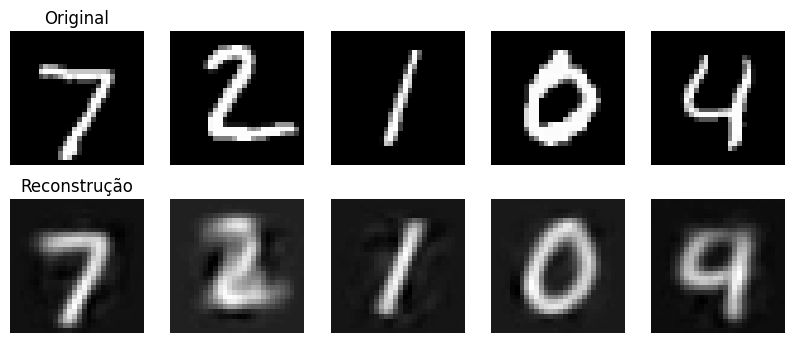

In [23]:
model = VAE(latente_dim=10)
state_dict = torch.load('models/model_vae_10.pth')
state_dict = {
    "encoder.0.weight": state_dict["encoder.linear_784_128.weight"],
    "encoder.0.bias": state_dict["encoder.linear_784_128.bias"],
    "encoder.2.weight": state_dict["encoder.linear_128_64.weight"],
    "encoder.2.bias": state_dict["encoder.linear_128_64.bias"],
    "encoder.4.weight": state_dict["encoder.linear_64_32.weight"],
    "encoder.4.bias": state_dict["encoder.linear_64_32.bias"],
    "encoder.6.weight": state_dict["encoder.linear_latente1.weight"],
    "encoder.6.bias": state_dict["encoder.linear_latente1.bias"],
    "encoder.7.weight": state_dict["encoder.linear_latente2.weight"],
    "encoder.7.bias": state_dict["encoder.linear_latente2.bias"],
    "decoder.0.weight": state_dict["decoder.linear_10_32.weight"],
    "decoder.0.bias": state_dict["decoder.linear_10_32.bias"],
    "decoder.2.weight": state_dict["decoder.linear_32_64.weight"],
    "decoder.2.bias": state_dict["decoder.linear_32_64.bias"],
    "decoder.4.weight": state_dict["decoder.linear_64_128.weight"],
    "decoder.4.bias": state_dict["decoder.linear_64_128.bias"],
    "decoder.6.weight": state_dict["decoder.latente_linear.weight"],
    "decoder.6.bias": state_dict["decoder.latente_linear.bias"]
}
model.load_state_dict(state_dict)
model.eval()
def plot_images(original_images, reconstructed_images, n):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
        
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstrução')
    plt.show()
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_images, test_labels = next(iter(test_loader))
test_images = test_images.view(-1, 28*28)



reconstructed_images = model.forward(torch.tensor(test_images[:5])).detach().numpy()
plot_images(test_images, reconstructed_images, 5)

In [1]:
%run "classification.py"

AutoEncoder(
  (encoder): Sequential(
    (linear_784_128): Linear(in_features=784, out_features=128, bias=True)
    (act_128): ReLU()
    (linear_128_64): Linear(in_features=128, out_features=64, bias=True)
    (act_64): ReLU()
    (linear_64_32): Linear(in_features=64, out_features=32, bias=True)
    (act_32): ReLU()
    (linear_latente): Linear(in_features=32, out_features=2, bias=True)
  )
  (classifier): Linear(in_features=2, out_features=10, bias=True)
  (decoder): Sequential(
    (linear_2_32): Linear(in_features=2, out_features=32, bias=True)
    (act_32): ReLU()
    (linear_32_64): Linear(in_features=32, out_features=64, bias=True)
    (act_64): ReLU()
    (linear_64_128): Linear(in_features=64, out_features=128, bias=True)
    (act_128): ReLU()
    (latente_linear): Linear(in_features=128, out_features=784, bias=True)
  )
)
Epoch: 1/5, Loss: 0.8135
Epoch 1/5, Test Accuracy: 91.47%
Epoch: 2/5, Loss: 0.4102
Epoch 2/5, Test Accuracy: 93.22%
Epoch: 3/5, Loss: 0.3094
Epoch 3/5, Te

Estes dois últimos exemplos voltam a usar o espaço latente bidimensional em suas arquiteturas. Entretanto, a perda de reconstrução é combinada com uma perda de classificação, entropia cruzada, entre a saída do encoder passada para uma camada linear de dimensão 10 e o rótulo da imagem. A construção desse espaço latente auxiliado por uma perda de classificação aparenta ter sido beneficiada, é possível observar clusters bem definidos como no exemplo anterior porém mantendo o mínimo de informação possível da imagem original. Entretanto, a perda combinada aparentou ter um efeito negativo na capacidade de reconstrução do decoder. No caso da rede convolucional o decoder passou a não reproduzir mais nenhuma imagem. Tal fenômeno pode ter ocorrido por conta dos parâmetros da rede terem convergido a um mínimo local onde a perda representada por uma imagem completamente

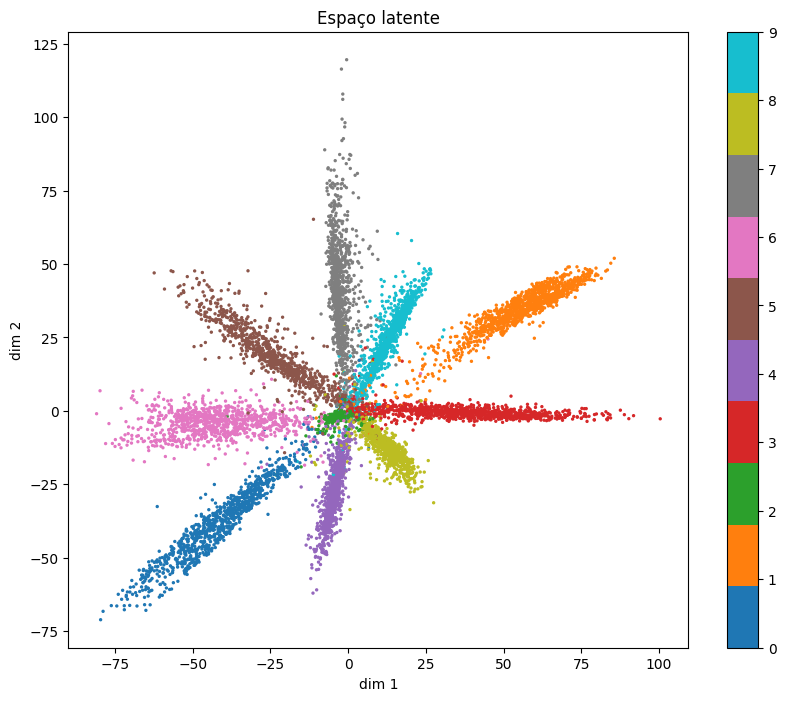

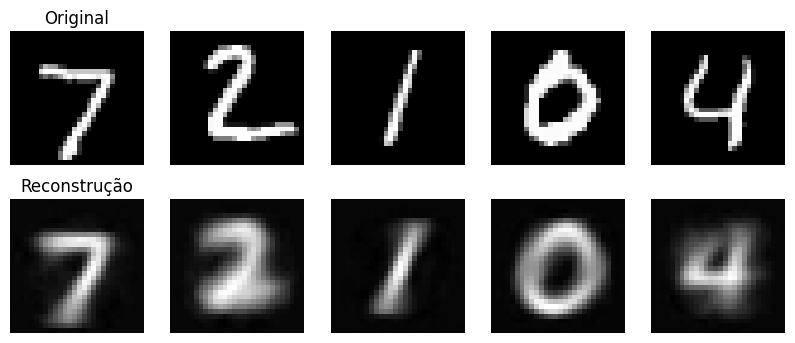

In [12]:
model = MLPAutoEncoder()
state_dict = torch.load('models/model_mlp_classification_2.pth')

state_dict = {
    'encoder.0.weight': state_dict['encoder.linear_784_128.weight'],
    'encoder.0.bias': state_dict['encoder.linear_784_128.bias'],
    'encoder.2.weight': state_dict['encoder.linear_128_64.weight'],
    'encoder.2.bias': state_dict['encoder.linear_128_64.bias'],
    'encoder.4.weight': state_dict['encoder.linear_64_32.weight'],
    'encoder.4.bias': state_dict['encoder.linear_64_32.bias'],
    'encoder.6.weight': state_dict['encoder.linear_latente.weight'],
    'encoder.6.bias': state_dict['encoder.linear_latente.bias'],
    'decoder.0.weight': state_dict['decoder.linear_2_32.weight'],
    'decoder.0.bias': state_dict['decoder.linear_2_32.bias'],
    'decoder.2.weight': state_dict['decoder.linear_32_64.weight'],
    'decoder.2.bias': state_dict['decoder.linear_32_64.bias'],
    'decoder.4.weight': state_dict['decoder.linear_64_128.weight'],
    'decoder.4.bias': state_dict['decoder.linear_64_128.bias'],
    'decoder.6.weight': state_dict['decoder.latente_linear.weight'],
    'decoder.6.bias': state_dict['decoder.latente_linear.bias']
}
model.load_state_dict(state_dict)
model.eval()
def plot_images(original_images, reconstructed_images, n):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstrução')
    plt.show()
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_images, test_labels = next(iter(test_loader))
test_images = test_images.view(-1, 28*28)
encoded_images = model.encoder(test_images).detach().numpy()
test_labels = test_labels.numpy()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=test_labels, cmap='tab10', s=2)
plt.colorbar(scatter)
plt.title('Espaço latente')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()

reconstructed_images = model.decoder(torch.tensor(encoded_images[:5])).detach().numpy()
plot_images(test_images, reconstructed_images, 5)

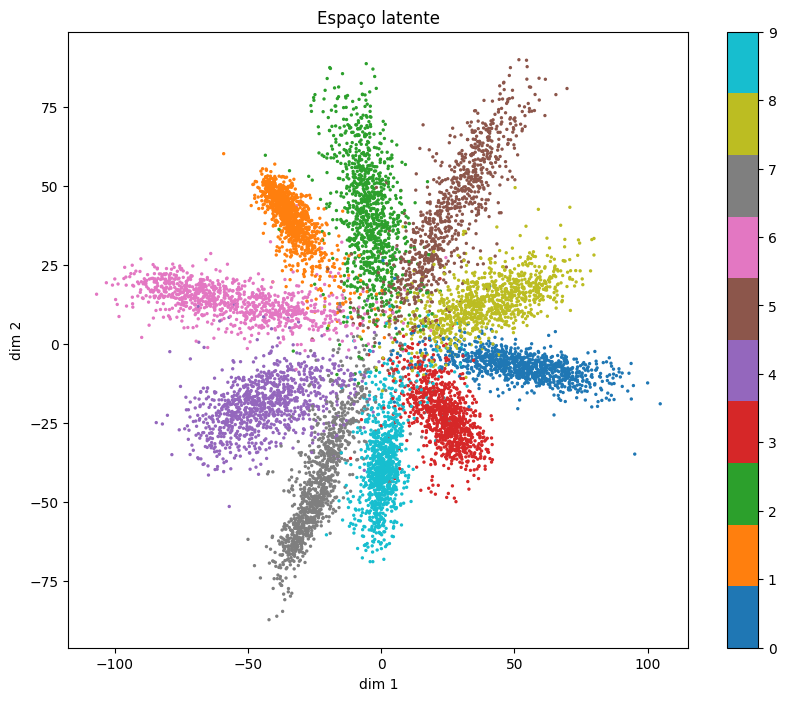

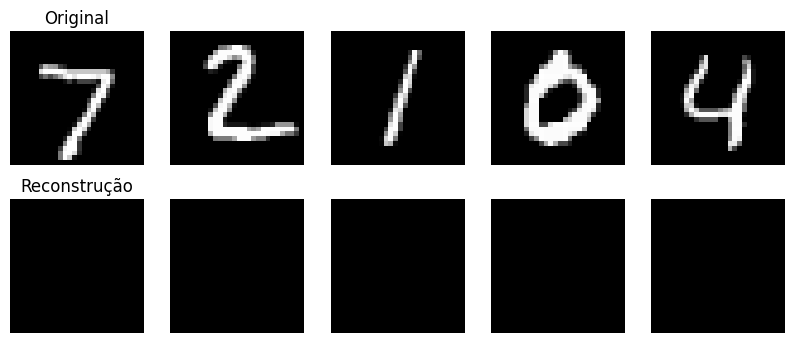

In [9]:
model = ConvolutionalAutoEncoder()
state_dict = torch.load('models/model_conv_classification_2.pth')
state_dict = {
    "encoder.0.weight": state_dict["encoder.conv_1_16.weight"],
    "encoder.0.bias": state_dict["encoder.conv_1_16.bias"],
    "encoder.3.weight": state_dict["encoder.conv_16_32.weight"],
    "encoder.3.bias": state_dict["encoder.conv_16_32.bias"],
    "encoder.6.weight": state_dict["encoder.conv_32_64.weight"],
    "encoder.6.bias": state_dict["encoder.conv_32_64.bias"],
    "encoder.10.weight": state_dict["encoder.linear_latente.weight"],
    "encoder.10.bias": state_dict["encoder.linear_latente.bias"],
    "decoder.0.weight": state_dict["decoder.latente_linear.weight"],
    "decoder.0.bias": state_dict["decoder.latente_linear.bias"],
    "decoder.2.weight": state_dict["decoder.conv_64_64.weight"],
    "decoder.2.bias": state_dict["decoder.conv_64_64.bias"],
    "decoder.4.weight": state_dict["decoder.conv_64_32.weight"],
    "decoder.4.bias": state_dict["decoder.conv_64_32.bias"],
    "decoder.6.weight": state_dict["decoder.conv_32_1.weight"],
    "decoder.6.bias": state_dict["decoder.conv_32_1.bias"]
}
model.load_state_dict(state_dict)
model.eval()
def plot_images(original_images, reconstructed_images, n):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstrução')

    plt.show()
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_images, test_labels = next(iter(test_loader))
encoded_images = model.encoder(test_images).detach().numpy()
test_labels = test_labels.numpy()
test_images = test_images.view(-1, 28*28)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=test_labels, cmap='tab10', s=2)
plt.colorbar(scatter)
plt.title('Espaço latente')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()
reconstructed_images = model.decoder(torch.tensor(encoded_images[:5])).detach().numpy()
plot_images(test_images, reconstructed_images, 5)